в качестве подопытного решил взть следующий датафрейм: https://www.kaggle.com/radmirzosimov/telecom-users-dataset  
по прогнозированию попадет ли клиент в отток или нет

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("./data/telecom_users.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)

In [4]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes


In [5]:
#  посмотрим сколько наблюдений имеется
df.shape

(5986, 21)

In [6]:
#  поменяем целевую переменную на бинарный класс, вместо Yes, No чтобы потом не мучиться с этим
df.loc[df["Churn"] == "No", "Churn"] = 0
df.loc[df["Churn"] == "Yes", "Churn"] = 1

In [7]:
#  не такой уж большой фрейм, но в целом я думаю подойдет для тренировочных целей
#  посмотрим датафрейм на пропущенные значения
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
#  посмотрим на соотношение классов
df["Churn"].value_counts(normalize=True)

0    0.734881
1    0.265119
Name: Churn, dtype: float64

In [9]:
#  задача как обычно разбалансированная, но думаю для текущих целей не будем бороться с разбалансированностью классов

In [10]:
#  пропщенных значений нет, уже хорошо)) разделим на тренировочный и тестовый
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, :"TotalCharges"], df["Churn"], test_size=0.3, 
                                                    random_state=42)

In [11]:
X_train.shape, y_train.shape

((4190, 20), (4190,))

In [12]:
X_test.shape, y_test.shape

((1796, 20), (1796,))

In [13]:
#  посмотрим поближе на датафрейм и сделаем пайплайн по его изменению
#  столбец customerID нам нафиг не нужен, поэтому в пайплайне его удалим 

#  столбцы gender, Partner, Dependents закодируем с помощью OrdinalEncoder, потому что данные фичи предоставляют бинарный класс
#  столбец SeniorCitizen оставим как есть, он и так уже реализует бинарный класс

#  далее идет два интересных столбца PhoneService и MultipleLines, которые взаимосвязаны. Поскольку данные категориальные 
#  и кодироваться они будут через OneHot, то попробуем их объединить. Потому что сейчас получается 5 вариантов OneHot, но можно
#  их уменьшить. (вообще по хорошему для всего того что я делаю нужно параллельно статтесты проводить чтобы доказывать
#  эти гипотезы, но предположим что я все это сделал и тесты дали добро на это все))) по столбцу PhoneService может быть два 
#  варианта Yes и No, а по столбцу MultipleLines можно наблюдать Yes, No и  No phone service. Логически данные в двух столбцах
#  пересекаются на уровнях No из первого столбца и No phone services из второго столбца, а Yes из первого столбца означает 
#  что клиент может иметь выделенные линии Yes или не иметь. Поэтому предлагаю смерджить два столбца и сделать один в котором 
#  будут следующие признаки. Yes - если клиент имеет телефонные сервисы, No - если клиент не имеет телефонные сервисы и multilines
#  если у клиента подключена опция выделенных линий...такой трансформер придется писать руками

#  фичу tenure предлагаю представить в виде логарифмически нормированного признака. Только надо не забыть, что там может быть 0

# посмотрим на следующие признаки [InternetService, OnlineSecurity, OnlineBackup, 
#                                  DeviceProtection, TechSupport,StreamingTV, StreamingMovies]

In [14]:
feature_review = pd.DataFrame()
for col in ["InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
            "TechSupport","StreamingTV", "StreamingMovies"]:
    temp_df = pd.DataFrame(df[col].value_counts())
    feature_review = feature_review.merge(temp_df, how="outer", left_index=True, right_index=True)
feature_review.fillna(0, inplace=True)

In [15]:
feature_review

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
DSL,2068.0,0.0,0.0,0.0,0.0,0.0,0.0
Fiber optic,2627.0,0.0,0.0,0.0,0.0,0.0,0.0
No,1291.0,2982.0,2605.0,2640.0,2960.0,2389.0,2356.0
No internet service,0.0,1291.0,1291.0,1291.0,1291.0,1291.0,1291.0
Yes,0.0,1713.0,2090.0,2055.0,1735.0,2306.0,2339.0


In [16]:
#  как видно почти все колонки кроме InternerService имеют почити бинарные признаки. Как видно, отсутсвие подключения интернета
#  так же ведет за собой отсутствие прочих сервисов связанных с интернетом, что в целом логично. Поэтому предлагаю следюущее
#  столбец с интернет сервисом оставим без изменений, а остальные столбцы преобразуем к одному столбцу, в котором будет
#  одна бинарная фича.....есть дополнительные интернет услуги или нет. Потому что скорее всего, клиент который дополнительно
#  к услуге интернета подключает дополнительные услуги, навряд ли будет менять провайдера. Опять же это предположение
#  и по хорошему это надо проверять дополнительными тестами....в данном случае просто хочется потренироваться в написании 
#  пайплайнов))

In [17]:
#  по фиче Contract ничего делать не будем, потому что в принципе градация там нормальная и достаточно OneHot
#  колонки PaperlessBilling и PaymentMethod тоже взаимосвязаны, но образатывать их особо тоже не будем.
#  для PaperlessBilling OrdinalEncoder, а для PaymentMethod OneHot отлично подойдет
#  MonthlyCharges и TotalCharges сделаем дополнительно логарифмическое преобразование

In [18]:
#  напишем трансформеры

In [19]:
#  логарифмическое преобразование
#  плюс добавим стандартизирование исходной фичи
class PolyFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        out = X.copy()
        for col in self.col_names:
            out[f"{col}_log"] = np.where(out[col] == 0, 1, out[col])
            out[f"{col}_log"] = np.log(out[f"{col}_log"])
            
            out[col] = StandardScaler().fit_transform(out[[col]])
        return out

In [20]:
#  ручная подготовка датасета
class PrepareDF(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        out = X.copy()
        out.drop(columns=["customerID"], inplace=True)
        out.loc[(out["PhoneService"] == "Yes") & (out["MultipleLines"] == "No"), "PhoneServ"] = "Phone"
        out.loc[(out["PhoneService"] == "Yes") & (out["MultipleLines"] == "Yes"), "PhoneServ"] = "MultilinePhone"
        out.loc[(out["PhoneService"] == "No") & (out["MultipleLines"] == "No phone service"), "PhoneServ"] = "NoPhone"
        out.drop(columns=["PhoneService", "MultipleLines"], inplace=True)
        
        out["ExtraInternetServ"] = pd.NA
        out.loc[(df["OnlineSecurity"] == "Yes") | 
                (df["OnlineBackup"] == "Yes") |
                (df["DeviceProtection"] == "Yes") |
                (df["TechSupport"] == "Yes") |
                (df["StreamingTV"] == "Yes") |
                (df["StreamingMovies"] == "Yes"), "ExtraInternetServ"] = 1
        out["ExtraInternetServ"].fillna(0, inplace=True)
        out.drop(columns=["OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                          "TechSupport","StreamingTV", "StreamingMovies"], 
                 inplace=True)
        
#         в процессе выяснилось что в графе TotalCharges на самом деле текст и есть пропущенные значения в виде пробелов.
#         поэтому делаем замену, тоже ручками
        out.loc[out["TotalCharges"] == " ", "TotalCharges"] = 0
        out["TotalCharges"] = out["TotalCharges"].astype("float64")
    
        return out

In [21]:
#  Есть определенные проблемы с реализацией OrdinalEnoder в sklearn, чтобы ее обойти нужно дописать свой класс 
class OrdEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        out = X.copy()
        df_for_replace = pd.DataFrame()
        for col in self.col_names:
            temp_col = OrdinalEncoder(categories="auto").fit_transform(out[[col]])
            temp_df = pd.DataFrame(temp_col, columns=[col])
            temp_df = temp_df.astype("int32")
            df_for_replace = pd.concat([df_for_replace, temp_df], axis=1)
        out.drop(columns=self.col_names, inplace=True)
        out.reset_index(inplace=True, drop=True)
        df_for_replace.reset_index(inplace=True, drop=True)
        out = pd.concat([out, df_for_replace], axis=1)
        return out

In [22]:
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.get_dummies(X, columns=self.col_names)

In [23]:
#  посмотрим как отрабатывает наш ручной преобразователь
PrepareDF().transform(X_train).head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,PhoneServ,ExtraInternetServ
1187,Female,0,No,No,34,No,Month-to-month,No,Mailed check,20.35,673.20,Phone,0
5080,Female,0,Yes,No,72,No,Two year,No,Bank transfer (automatic),19.40,1496.45,Phone,0


In [24]:
#  посмотрим оставляет ли пропущенные значения
PrepareDF().transform(X_train).isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
InternetService      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
PhoneServ            0
ExtraInternetServ    0
dtype: int64

In [25]:
#  нет, отлично, тогда поехали дальше, соберем трансформер как описано было раньше

In [26]:
transformer = make_pipeline(
                            PrepareDF(),
                            OrdEncoder(["gender", "Partner", "Dependents", "PaperlessBilling"]),
                            PolyFeatureScaler(["tenure", "MonthlyCharges", "TotalCharges"]),
                            OHEEncoder(["InternetService", "Contract", "PaymentMethod", "PhoneServ"])
                            )

In [27]:
transformer.fit_transform(X_train).head(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,ExtraInternetServ,gender,Partner,Dependents,PaperlessBilling,tenure_log,MonthlyCharges_log,TotalCharges_log,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneServ_MultilinePhone,PhoneServ_NoPhone,PhoneServ_Phone
0,0,0.058869,-1.496626,-0.718592,0,0,0,0,0,3.526361,3.013081,6.512042,0,0,1,1,0,0,0,0,0,1,0,0,1
1,0,1.605839,-1.528325,-0.356514,0,0,1,0,0,4.276666,2.965273,7.310851,0,0,1,0,0,1,1,0,0,0,0,0,1


In [28]:
#  вроде отрабатывает правильно, после всех преобразований получилась 25 фичей при исходных 20....в общем неплохо, 
#  не наплодили лишнего, сделаем простой классификатор на деревьях решений

In [29]:
forest_clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion="entropy", max_depth=7, random_state=42)

In [30]:
forest_pipe = make_pipeline(transformer, forest_clf)

In [31]:
forest_pipe.fit(X_train, y_train.astype("int"))

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preparedf', PrepareDF()),
                                 ('ordencoder',
                                  OrdEncoder(col_names=['gender', 'Partner',
                                                        'Dependents',
                                                        'PaperlessBilling'])),
                                 ('polyfeaturescaler',
                                  PolyFeatureScaler(col_names=['tenure',
                                                               'MonthlyCharges',
                                                               'TotalCharges'])),
                                 ('oheencoder',
                                  OHEEncoder(col_names=['InternetService',
                                                        'Contract',
                                                        'PaymentMethod',
                                                        'PhoneServ']))])),
      

In [32]:
forest_preds = forest_pipe.predict_proba(X_test)[:, 1]

In [33]:
#  оценим что получилось
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, confusion_matrix

In [34]:
roc_score = roc_auc_score(y_test.astype("int"), forest_preds)
roc_score

0.837031882160605

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test.astype("int"), forest_preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.301302, F-Score=0.611, Precision=0.513, Recall=0.756


In [36]:
confusion_matrix(y_test.astype("int"), forest_preds>thresholds[ix])

array([[1001,  332],
       [ 114,  349]], dtype=int64)

In [37]:
#  ну в целом не самый лучший классификатор, но и не самый худший. Мы неплохо прогнозируем целевой класс, но очень много 
#  совершаем ложноположительных ошибок. В итоге если удем работать по этой модели будем тратить деньги на лиц, которые на самом
#  деле никуда утекать не будут....

In [38]:
import shap
shap.initjs()
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
explainer = shap.TreeExplainer(forest_pipe.get_params()["steps"][-1][-1])

In [40]:
shap_values = explainer.shap_values(transformer.fit_transform(X_train))

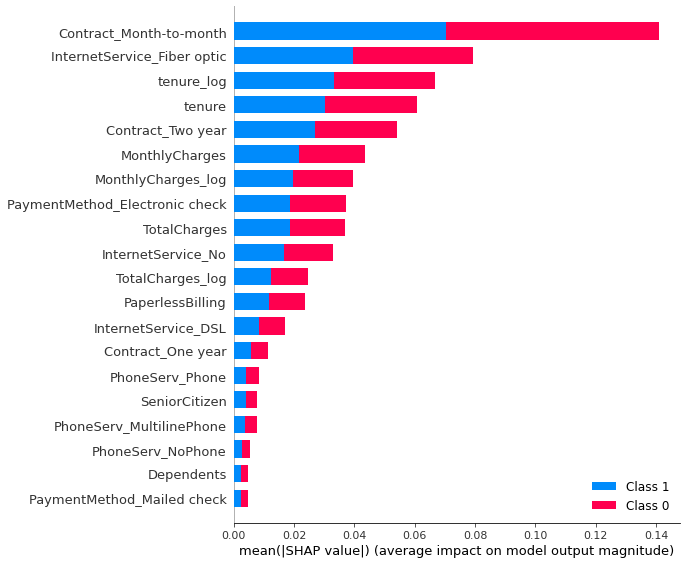

In [41]:
shap.summary_plot(shap_values, transformer.fit_transform(X_train))

In [42]:
#  не знаю почему у меня именно такой график получается, возможно связано с тем что я использовал модель из библиотеки sklearn
#  в итоге как мы видим основные фичи, которые влияют на класс пользователя, это месячный ид договора, 
#  наличие оптоволокна и продолжительность пользования сервисом....
#  при этом логарифмическое преобразование особых результатов не дает

#  фичи самми по себе тоже не дают ответа, какая больше всего влияет на какой класс....средниее влияние кажждой фичи на каждый
#  класс, примерно одинаково. У нас конечно модель не самый супер-пупер, но возможно это связано с разбалансированными
#  данными или природой датасета, собранной стратифицированно по каждой фиче
#  посмотрим на какие-нибудь предсказания отдельно

In [69]:
#  посмотрим на 23 пользователя
shap.force_plot(explainer.expected_value[0], shap_values[0][23,:], 
                transformer.fit_transform(X_train).iloc[23, :])

In [68]:
forest_pipe.predict_proba(X_train)[23]

array([0.99529791, 0.00470209])

In [70]:
#  вероятность того что пользователь останется с нами почти единица, и в большей степени этой оценке по классу 0 способствуют 
#  оценки продолжительности пользования сервисом и двухгодовой вид подписанного контракта

In [71]:
#  посмотрим на 1048 пользователя 
shap.force_plot(explainer.expected_value[0], shap_values[0][1048,:], 
                transformer.fit_transform(X_train).iloc[1048, :])

In [72]:
forest_pipe.predict_proba(X_train)[1048]

array([0.96959786, 0.03040214])

In [73]:
#  примерно та же самая картина, мы видим двухгодичный контракт, который вносит основную значимость в предсказание

In [80]:
#  возьмем объекты из класса 1

In [85]:
y_train.reset_index(drop=True)[y_train.reset_index(drop=True) == 1].index

Int64Index([   7,   29,   31,   36,   41,   44,   45,   49,   50,   53,
            ...
            4156, 4157, 4161, 4162, 4169, 4170, 4176, 4178, 4181, 4182],
           dtype='int64', length=1124)

In [86]:
#  ну посмотрим на 53 и 4169 пользователя

In [87]:
shap.force_plot(explainer.expected_value[1], shap_values[1][53,:], 
                transformer.fit_transform(X_train).iloc[53, :])

In [88]:
forest_pipe.predict_proba(X_train)[53]

array([0.10240672, 0.89759328])

In [89]:
#  в данном случае мы уже прогнозируем 1 класс и основное влияние идет по признакам продолжительности пользования. Видим 
# что логарифмическое преобразование показывает 0, а это значит что логарифм брался по нулю и видим, что пользователь 
# подписал месячный контракт. Поэтому делаем вывод что пользователь новый.....вохможно нужно на него подействовать и предложить
# что-то, чтобы он не отчурнился

In [90]:
shap.force_plot(explainer.expected_value[1], shap_values[1][4169,:], 
                transformer.fit_transform(X_train).iloc[4169, :])

In [91]:
forest_pipe.predict_proba(X_train)[4169]

array([0.80294718, 0.19705282])

In [92]:
#  А вот тут кстати видим ошибку первого рода. Пользователь относится к классу 1, а мы прогнозируем нулевой класс
#  и тут мы в принципе можем увидеть как работает модель. Основная фича которая привносит предсказательную силу - это
# Contract_Month-to_month, другими словами, модель видит что пользователь не заключил месячный контракт, а заключил какой-то 
# другой - видимо годовой, потому что там только три градациии по этой фиче, а двухгодовой контракт тоже указан что не заключен 
# (первая красная фича). А скорее всего в данных тот, кто заключал месячный контракт более всего и чурнился, поэтому для
# модели это и является основной фичей....на которую она опирается. 
# При этом у нас пользователь провел оптическую линию (вторая синяя фича) и для модели это тоже судя по всему явнй признак

Только позже заметил, что нужно оценивать по тестовой выборке...
Не знаю насколько правильно оценивать на тренировочном наборе, но вроде в репозитории проекта shap давали примеры тоже на траин датасете....
Ну и немножечко лень менять код выше))....надеюсь я не сильно ошибаюсь 

Построим график для топ 10% наблюдений, которые дают положительный класс

In [101]:
top_10 = pd.Series(forest_preds)

In [114]:
#  нам ужно взять экземпляров положительного класса
int(top_10.shape[0] * 0.1)

179

In [115]:
#  для дальнейшей проверки
top_10.sort_values(ascending=True)

57      0.000600
1560    0.000746
1357    0.001140
1309    0.001280
854     0.001517
          ...   
296     0.836140
1566    0.839121
458     0.858777
1014    0.877172
1368    0.880902
Length: 1796, dtype: float64

In [117]:
top10_indexes = top_10.sort_values(ascending=True).take(range(179)).index
top10_indexes

Int64Index([  57, 1560, 1357, 1309,  854, 1038,  112,  539,  535, 1404,
            ...
             896,  834, 1788,  359,  759, 1533, 1092, 1120, 1207,  244],
           dtype='int64', length=179)

In [118]:
#  отлично, отработало правильно, индексы идут верно. Теперь нужно передать это все в force_plot

In [119]:
shap.force_plot(explainer.expected_value[1], shap_values[1][top10_indexes,:], 
                transformer.fit_transform(X_train).iloc[top10_indexes, :])

In [120]:
#  если покопаться в шкалах графика, то видно что выборка в принципе не имеет каких-то конкретно выделяющихся фичей, которые 
# объясняли бы какой-либо класс. все графики примерно одинаково распределены и не имеют явновыраженной скошенности в 0 или в 1 класс
# Если посмотреть на Contract_Month-to-month....основная фича согласно summary_plot, 
# то в целом 50/50 она влияет первый класс...как и все остальные фичи. При этом разброс примерно одинаковый что синего что красного
# графика, поэтому возможно наша модель не самая удачная